In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold,GroupKFold
from sklearn import preprocessing
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
data = pd.read_csv( 'ripple_event_chars.csv')
data

,inst_freq,avg_freq,amplitude,auc,duration,p2p_dist,power,entropy,num_of_peaks,spect_entropy,hour,condition,rat
0,134.335052,132.916221,298.317234,6.165582,0.073333,501.947144,11420.950369,0.976021,11.0,5.145256,1,HC,1
1,127.037757,124.305592,497.048291,8.996310,0.058333,860.219762,36439.500384,0.994694,8.0,4.768099,1,HC,1
2,134.499346,138.733123,296.428197,8.637603,0.106667,565.767987,11621.768158,0.993651,16.0,5.023939,1,HC,1
3,138.955976,137.832377,225.212268,5.439281,0.065000,378.733588,10464.946537,0.995727,9.0,5.058782,1,HC,1
4,142.703078,135.915989,203.127282,5.917495,0.093333,338.102554,6392.267900,1.109268,14.0,4.985887,1,HC,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25690,175.396636,173.234692,213.669689,3.651451,0.061667,403.787040,6504.100242,0.999473,10.0,5.360476,5,RET,4
25691,133.087535,134.434527,222.708906,4.273101,0.066667,398.623953,7654.711799,1.286397,10.0,5.156993,5,RET,4
25692,149.976357,176.870183,727.327213,8.852424,0.085000,1215.197614,33892.587542,1.236085,13.0,5.493668,5,RET,4
25693,152.728029,155.917298,222.783436,12.211191,0.203333,397.673340,6237.343611,0.996896,32.0,5.386663,5,RET,4


## converting Object columns to Categorical Data

In [66]:
data['condition'] = pd.Categorical(data.condition)
data['rat'] = pd.Categorical(data.rat)
data['rat'] = pd.Categorical(data.rat)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25695 entries, 0 to 25694
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   inst_freq      25695 non-null  float64 
 1   avg_freq       25695 non-null  float64 
 2   amplitude      25695 non-null  float64 
 3   auc            25695 non-null  float64 
 4   duration       25695 non-null  float64 
 5   p2p_dist       25695 non-null  float64 
 6   power          25695 non-null  float64 
 7   entropy        25695 non-null  float64 
 8   num_of_peaks   25695 non-null  float64 
 9   spect_entropy  25695 non-null  float64 
 10  hour           25695 non-null  int64   
 11  condition      25695 non-null  category
 12  rat            25695 non-null  category
dtypes: category(2), float64(10), int64(1)
memory usage: 2.2 MB


## Dataframe of short ripples in the first hour

In [31]:
short_ripple_h1 = data.loc[data.duration < 0.1].copy()
short_ripple_h1 = short_ripple_h1.loc[data.hour==2]
short_ripple_h1.head(5)

,inst_freq,avg_freq,amplitude,auc,duration,p2p_dist,power,entropy,num_of_peaks,spect_entropy,hour,condition,rat
623,135.921003,140.991078,299.138547,7.566730,0.095000,536.385752,10697.363856,0.998001,14.0,5.215154,2,HC,1
626,152.099910,147.352061,257.422611,4.468201,0.060000,402.189407,8494.558142,0.979869,9.0,5.502780,2,HC,1
630,145.690507,151.630610,263.189711,4.447380,0.058333,485.471857,9913.944058,0.994694,8.0,5.544037,2,HC,1
631,127.553050,137.756001,249.348088,5.097314,0.081667,369.520004,6538.296863,1.092423,13.0,5.228577,2,HC,1
632,161.316286,151.006164,241.635252,5.197277,0.086667,343.601958,6102.606608,1.111058,15.0,5.446990,2,HC,1


In [70]:
data2 = data.copy()

## Pairwise scatterplot of a subset of features

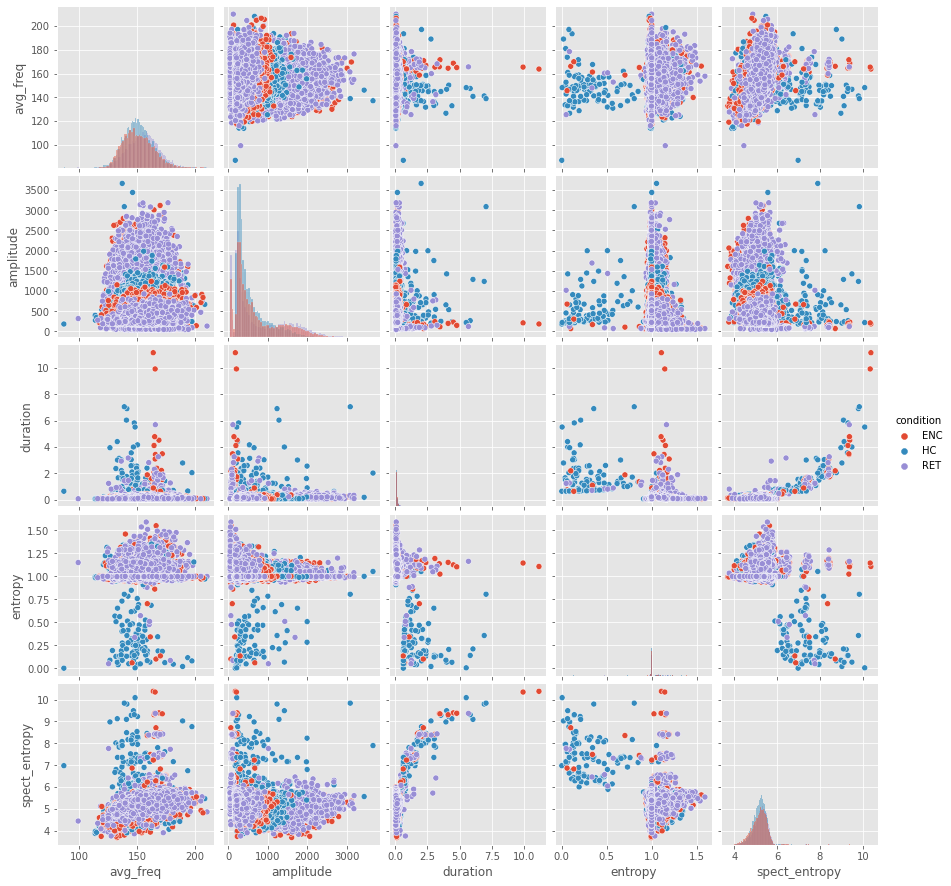

In [93]:
data3 = data[['avg_freq','amplitude','duration', 'entropy' , 'spect_entropy','condition']]
sns.pairplot(data3, hue = 'condition',diag_kind="hist")

In [72]:
cols = ['inst_freq', 'avg_freq','amplitude', 'auc','duration', 'p2p_dist', 'power', 'entropy', 'num_of_peaks', 'spect_entropy','hour']
data4 = data[cols].copy()

## Correlation Matrix of features

In [73]:
corr_mat = data4.corr(method='spearman')

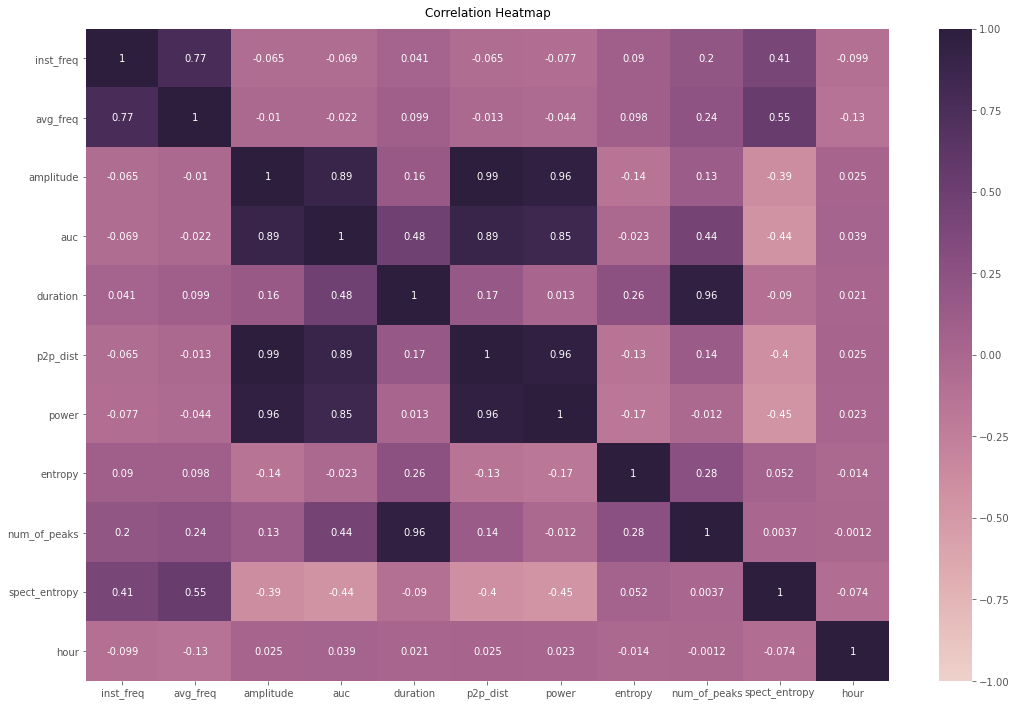

In [74]:
plt.figure(figsize=(18,12))
heatmap = sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True,cmap=sns.cubehelix_palette(as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Training models

### checking the balance of data between the 3 conditions

In [68]:
print(len(data[data.condition == 'HC'])/len(data))
print(len(data[data.condition == 'ENC'])/len(data))
print(len(data[data.condition == 'RET'])/len(data))

0.37544269313095935
0.3228643705000973
0.3016929363689434


### Decision Tree

              precision    recall  f1-score   support

         ENC       0.48      0.36      0.41      8296
          HC       0.54      0.70      0.61      9647
         RET       0.55      0.50      0.52      7752

    accuracy                           0.53     25695
   macro avg       0.53      0.52      0.52     25695
weighted avg       0.53      0.53      0.52     25695



AttributeError: 'DecisionTreeClassifier' object has no attribute 'feature_names_in_'

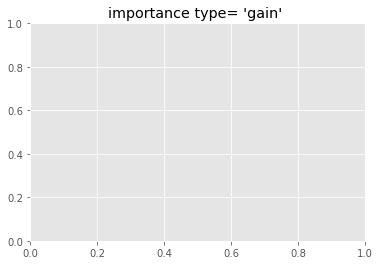

In [95]:
le = preprocessing.LabelEncoder()
groups=data2['rat']
y=le.fit_transform(data2['condition'])
X=data2.drop(['condition','rat'],axis=1)
n_folds=5

# kf = GroupKFold(n_splits=3)
kf=StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=42)

y_true=[]
y_hat=[]
feat_importance=np.array([0.0 for c in X.columns])

for train_index, test_index in kf.split(X, y):#kf.split(X, y,groups)
    X_train, y_train =X.loc[train_index,:], y[train_index]
    X_test, y_test = X.loc[test_index,:], y[test_index]
    model = DecisionTreeClassifier(max_depth=10).fit(X_train, y_train)
    feat_importance+=model.feature_importances_
    y_true+=list(y_test)
    y_hat+=list(model.predict(X_test))

print(classification_report(y_true,y_hat,target_names=le.classes_))

model.n_features_in_
plt.title("importance type= 'gain' ")
plt.bar(model.feature_names_in_,feat_importance/np.sum(feat_importance))
plt.xticks(rotation=90)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

plot_tree(model,feature_names=model.feature_names_in_,rounded=True,max_depth=2)
plt.show()

In [58]:
predicts = pd.DataFrame(columns= ['cond_pred'])
def pred(row):
    if (row[0] > row[1]) and (row[0] > row[2]):
        return 'HC'
    elif (row[1] > row[0]) and (row[1] > row[2]):
        return 'ENC'
    else:
        return 'RET'
predicts['cond_pred'] = y_hat.apply(pred, axis = 1)
predicts.cond_pred = pd.Categorical(predicts.cond_pred)
predicts.cond_pred

0        ENC
1        ENC
2        ENC
3        ENC
4        ENC
        ... 
25690    ENC
25691     HC
25692    ENC
25693    ENC
25694    ENC
Name: cond_pred, Length: 25695, dtype: category
Categories (3, object): ['ENC', 'HC', 'RET']

## Histograms of `average frequency` feature for each condition

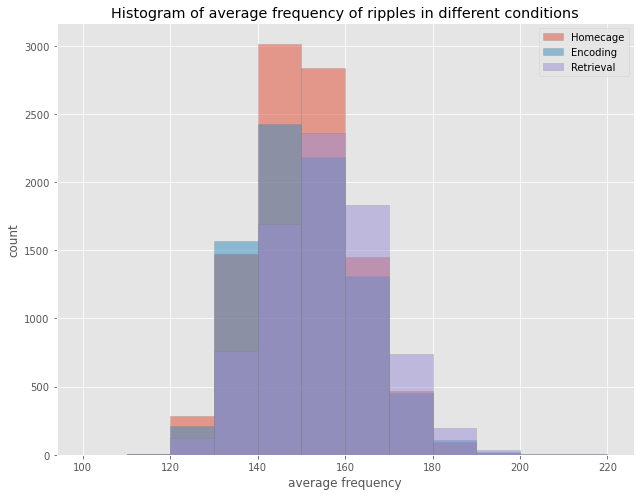

In [35]:
plt.figure(figsize = (9,7))
plt.hist(data.avg_freq[data.condition == 'HC'], alpha = 0.5,edgecolor = 'grey', label = 'Homecage', bins=[100,110,120,130,140,150,160,170,180,190,200,220])
plt.hist(data.avg_freq[data.condition == 'ENC'], alpha = 0.5,edgecolor = 'grey', label = 'Encoding', bins=[100,110,120,130,140,150,160,170,180,190,200,220])
plt.hist(data.avg_freq[data.condition == 'RET'], alpha = 0.5,edgecolor = 'grey', label = 'Retrieval',bins=[100,110,120,130,140,150,160,170,180,190,200,220])
plt.style.use('ggplot')
 
plt.title('Histogram of average frequency of ripples in different conditions')
plt.legend(loc='upper right')
 
plt.xlabel('average frequency')
plt.ylabel('count')
 
plt.tight_layout()
 
plt.show()

#### as we can see in the histograms above, this feature alone wouldn't be able to separate the conditions<br>very well. there's a lot of overlap between the histograms of the 3 conditions

## making a separate DataFrame for each hour of data

In [89]:
data_h1 = data[data.hour == 1].copy()
data_h2 = data[data.hour == 2].copy()
data_h3 = data[data.hour == 3].copy()
data_h4 = data[data.hour == 4].copy()
data_h5 = data[data.hour == 5].copy()

### Histograms of `average frequency` feature for each condition in different hours

#### Presleep (just 1 hour)

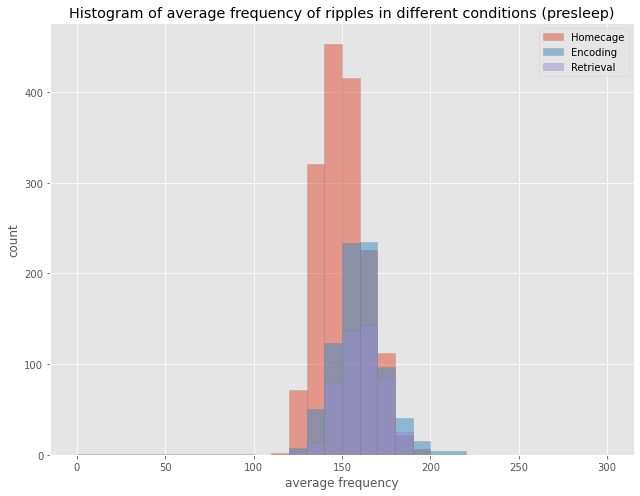

In [7]:
plt.figure(figsize = (9,7))
plt.hist(data_h1.avg_freq[data_h1.condition == 'HC'], alpha = 0.5,edgecolor = 'grey', label = 'Homecage', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h1.avg_freq[data_h1.condition == 'ENC'], alpha = 0.5,edgecolor = 'grey', label = 'Encoding', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h1.avg_freq[data_h1.condition == 'RET'], alpha = 0.5,edgecolor = 'grey', label = 'Retrieval',bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.style.use('ggplot')
 
plt.title('Histogram of average frequency of ripples in different conditions (presleep)')
plt.legend(loc='upper right')
 
plt.xlabel('average frequency')
plt.ylabel('count')
 
plt.tight_layout()
 
plt.show()

#### Postsleep (1st hour)

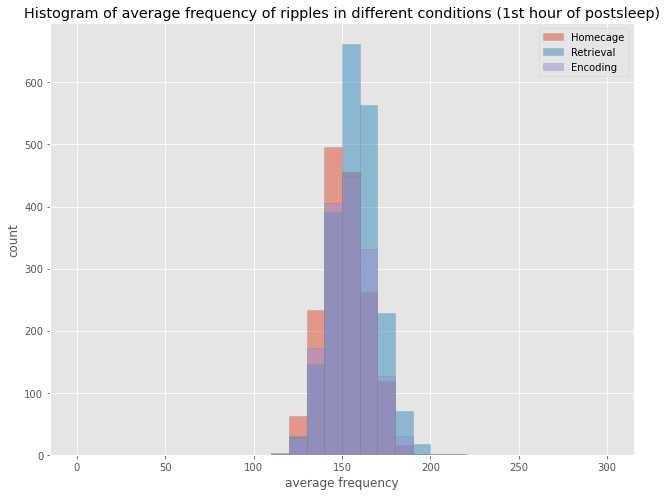

In [13]:
plt.figure(figsize = (9,7))
plt.hist(data_h2.avg_freq[data_h2.condition == 'HC'], alpha = 0.5,edgecolor = 'grey', label = 'Homecage', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h2.avg_freq[data_h2.condition == 'RET'], alpha = 0.5,edgecolor = 'grey', label = 'Retrieval',bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h2.avg_freq[data_h2.condition == 'ENC'], alpha = 0.5,edgecolor = 'grey', label = 'Encoding', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])

plt.style.use('ggplot')
 
plt.title('Histogram of average frequency of ripples in different conditions (1st hour of postsleep)')
plt.legend(loc='upper right')
 
plt.xlabel('average frequency')
plt.ylabel('count')
 
plt.tight_layout()
 
plt.show()

#### Postsleep (2nd hour)

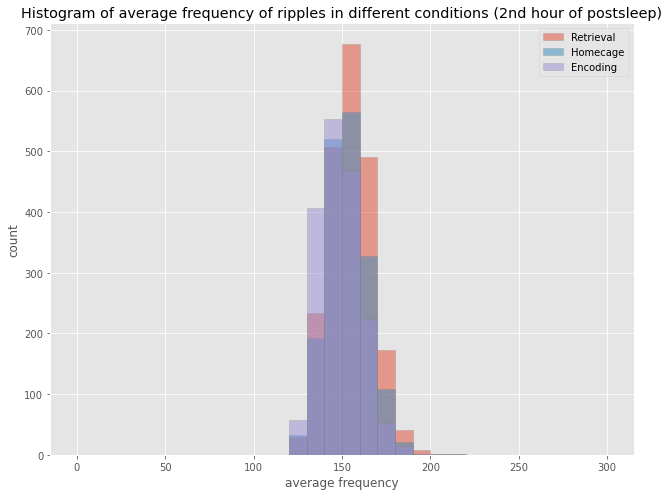

In [14]:
plt.figure(figsize = (9,7))
plt.hist(data_h3.avg_freq[data_h3.condition == 'RET'], alpha = 0.5,edgecolor = 'grey', label = 'Retrieval',bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h3.avg_freq[data_h3.condition == 'HC'], alpha = 0.5,edgecolor = 'grey', label = 'Homecage', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h3.avg_freq[data_h3.condition == 'ENC'], alpha = 0.5,edgecolor = 'grey', label = 'Encoding', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])

plt.style.use('ggplot')
 
plt.title('Histogram of average frequency of ripples in different conditions (2nd hour of postsleep)')
plt.legend(loc='upper right')
 
plt.xlabel('average frequency')
plt.ylabel('count')
 
plt.tight_layout()
 
plt.show()

#### Postsleep (3rd hour)

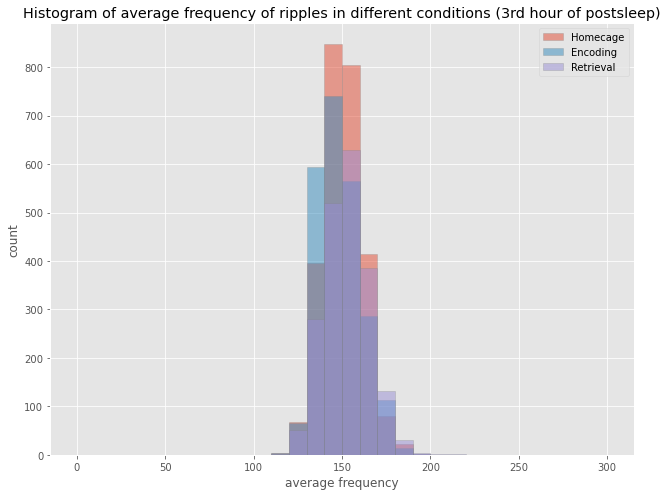

In [11]:
plt.figure(figsize = (9,7))
plt.hist(data_h4.avg_freq[data_h4.condition == 'HC'], alpha = 0.5,edgecolor = 'grey', label = 'Homecage', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h4.avg_freq[data_h4.condition == 'ENC'], alpha = 0.5,edgecolor = 'grey', label = 'Encoding', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h4.avg_freq[data_h4.condition == 'RET'], alpha = 0.5,edgecolor = 'grey', label = 'Retrieval',bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.style.use('ggplot')
 
plt.title('Histogram of average frequency of ripples in different conditions (3rd hour of postsleep)')
plt.legend(loc='upper right')
 
plt.xlabel('average frequency')
plt.ylabel('count')
 
plt.tight_layout()
 
plt.show()

#### Postsleep (4th hour)

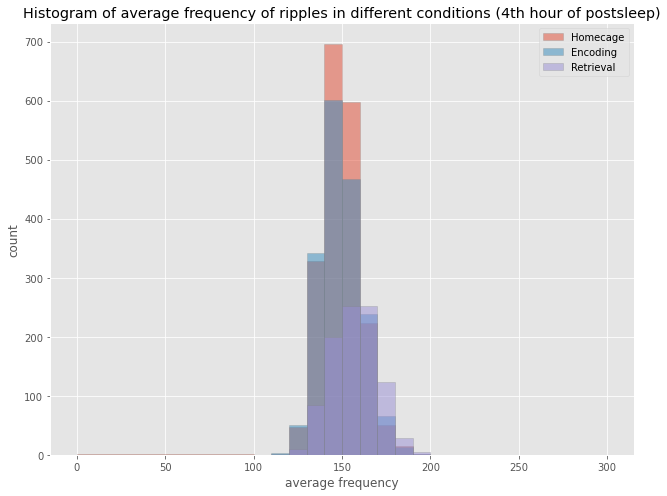

In [12]:
plt.figure(figsize = (9,7))
plt.hist(data_h5.avg_freq[data_h5.condition == 'HC'], alpha = 0.5,edgecolor = 'grey', label = 'Homecage', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h5.avg_freq[data_h5.condition == 'ENC'], alpha = 0.5,edgecolor = 'grey', label = 'Encoding', bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.hist(data_h5.avg_freq[data_h5.condition == 'RET'], alpha = 0.5,edgecolor = 'grey', label = 'Retrieval',bins=[0,100,110,120,130,140,150,160,170,180,190,200,220,300])
plt.style.use('ggplot')
 
plt.title('Histogram of average frequency of ripples in different conditions (4th hour of postsleep)')
plt.legend(loc='upper right')
 
plt.xlabel('average frequency')
plt.ylabel('count')
 
plt.tight_layout()
 
plt.show()

### Scatter plot of data points from the 3 conditions based on the 1st & 2nd principle component

Text(0.5, 1.0, 'Scatter plot based one the first 2 principle components')

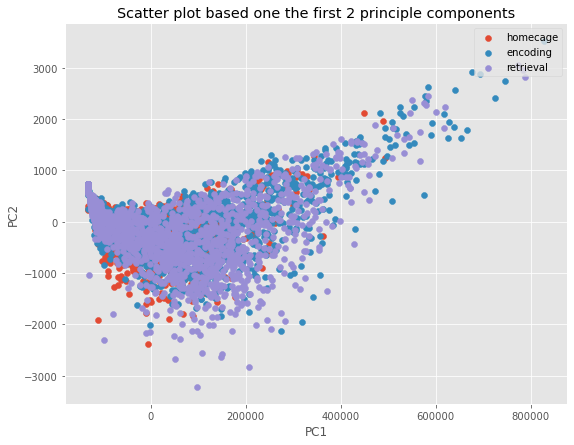

In [92]:
import numpy as np
from sklearn.decomposition import PCA
cols = ['inst_freq', 'avg_freq','amplitude', 'auc','duration', 'p2p_dist', 'power', 'entropy', 'num_of_peaks', 'spect_entropy']
X = data_h4[cols]
y = data_h3['condition']
pca = PCA(n_components=4)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(9,7))
plt.scatter(X_r[y == 'HC', 0], X_r[y == 'HC', 1], label='homecage')
plt.scatter(X_r[y == 'ENC', 0], X_r[y == 'ENC', 1], label='encoding')
plt.scatter(X_r[y == 'RET', 0], X_r[y == 'RET', 1], label='retrieval')
plt.legend(loc='upper right')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter plot based one the first 2 principle components')
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
